<a href="https://colab.research.google.com/github/juancpv/predictivemaintenance/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Antes de empezar a entrenar nuestro sistema de predicción de fallos. Aclaremos que estaremos trabajando en una maquina virtual con sistema operativo Linux y que usaremos python como lenguaje de programación.
Cada vez que queramos usar un comando de terminal de ubuntu, añadiremos al inicio de la instruccion el simbolo de exclamación (!)
A continuación importamos todas las librerias que usaremos a lo largo de este tutorial. A medida que las usemos las explicaremos en mas detalle.



In [0]:
import keras  #Biblioteca de redes neuronales 
import pandas as pd  #Biblioteca  para manipulación de datos
import numpy as np #Biblioteca para soporte  de operaciones matematicas de alto nivel en matrices y vectores.
import matplotlib.pyplot as plt #biblioteca para manejo de graficos

# Some tools
from sklearn import preprocessing #Paquete que permite la estandarizacion de datoscomo beneficio para los algoritmos de aprendizaje.
from sklearn.metrics import confusion_matrix, recall_score, precision_score # Paquete para medir el performance del clasificador.
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM


  **DATASETS.**

Para este ejercicio nosotros haremos uso de un dataset de Azure. Los datos consisten en tres archivos de texto: training, testing y ground truth para el caso especifico de 100 motores de aeronaves. 


*   El dataset de entrenamiento consiste de un conjunto de series de tiempo multivariable (21 sensores) con la unidad de tiempo medida en ciclos.
*   El dataset de pruebas, tiene el mismo esquema que el de entrenamiento, con la unica diferencia que estos no incluyen la etiqueta de ocurrencia de falla.
*   El datset de ground truth contiene información de ciclos restantes de trabajo de los motores




A continuación se dan los comandos para obtener los datasets (recuerde que esto es una maquina con sistema operativo Linux).





In [0]:
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt 
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt

--2019-10-16 22:54:57--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.10, 2620:1ec:bdf::10
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt.1’

PM_train.txt.1      100%[===================>]   3.35M  14.1MB/s    in 0.2s    

2019-10-16 22:54:57 (14.1 MB/s) - ‘PM_train.txt.1’ saved [3515356/3515356]

--2019-10-16 22:54:58--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.10, 2620:1ec:bdf::10
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt.1’

PM_test.txt.1       100%[===================>

Examinemos un poco los datos con los cuales vamos a trabajar (aqui comenzamos con el uso de PANDAS):

In [0]:
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.head(10) # Por defecto el numero de filas sera 5.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,NaN,NaN
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,1.3,47.36,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,NaN,NaN
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,21.61,553.85,2388.00,9040.80,1.3,47.24,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,NaN,NaN
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,21.61,553.69,2388.05,9046.46,1.3,47.29,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,NaN,NaN
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,21.61,553.59,2388.05,9051.70,1.3,47.03,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,NaN,NaN


Podemos observar como las dos ultimas columnas no tienen datos. Vamos a usar la funcion de pandas DROP para eliminar esas columnas.

In [0]:
train_df.drop(train_df.columns[[26,27]], axis=1, inplace=True)
train_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Dado que el dataset no contiene etiquetas para las  diferentes columnas, vamos a hacerlo tomando en cuenta el [template](https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2) de la pagina de Azure.

In [0]:
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df.head(10)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,1.3,47.36,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,21.61,553.85,2388.00,9040.80,1.3,47.24,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,21.61,553.69,2388.05,9046.46,1.3,47.29,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,21.61,553.59,2388.05,9051.70,1.3,47.03,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694


Hagamos lo mismo para los datos de prueba.

In [0]:
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.tail(5)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699
13095,100,198,0.0013,0.0003,100.0,518.67,642.95,1601.62,1424.99,14.62,21.61,552.48,2388.06,9155.03,1.3,47.80,521.07,2388.05,8214.64,8.4903,0.03,396,2388,100.0,38.70,23.1855


Miremos el archivo de ground truth:

In [0]:
truth_df = pd.read_csv('PM_truth.txt', sep= " ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [73]:
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.columns = ['cycle']
truth_df.head()

,cycle
0,1
1,2
2,3
3,4
4,5


**PRE-PROCESAMIENTO DE DATOS**
Antes de comenzar con el pre.rpocesamiento de datos. Vamos a comprender en que consisten los datos:
En el archivo de entrenamiento, cada motor empieza con un grado diferente de uso inicial y variaciones de manufactura. Se asume que cada motor opera normalmente al comienzo de cada serie de tiempo y comienza a degradarse en algun punto durante la serie del ciclo de operación. La degradación es progresiva y crece en magnitud. Cuando un nivel de umbral es alcanzado, el motor es considerado inseguro. Asi que el ultimo ciclo se puede considerar como el punto de falla del correspondiente motor.

Como una forma de practicar y ver lo que sucede en el dataset de entrenamiento. Visualice cual sería el punto de falla para cada motor: 


In [74]:
#organizar los datos por id y por ciclos:
train_df =train_df.sort_values(['id', 'cycle'])
train_df.head()
ultimo_ciclo = train_df.groupby('id')['cycle'].max()
ultimo_ciclo

id
1      192
2      287
3      179
4      189
5      269
6      188
7      259
8      150
9      201
10     222
11     240
12     170
13     163
14     180
15     207
16     209
17     276
18     195
19     158
20     234
21     195
22     202
23     168
24     147
25     230
26     199
27     156
28     165
29     163
30     194
      ... 
71     208
72     213
73     213
74     166
75     229
76     210
77     154
78     231
79     199
80     185
81     240
82     214
83     293
84     267
85     188
86     278
87     178
88     213
89     217
90     154
91     135
92     341
93     155
94     258
95     283
96     336
97     202
98     156
99     185
100    200
Name: cycle, Length: 100, dtype: int64

Como pudo notar existen 100 motores y por ejemplo el motor 1 fallará en el ciclo 192 y el motor 100 fallará en el ciclo 200.
Para el dataset de prueba, el esquema es identico al dataset de entrenamiento, solo que en este caso el ultimo ciclo no representa el punto de falla para un motor en particular.

El dataset ground truth tendrá entonces  el ciclo donde fallará cada motor del dataset de prueba.



Existen varias preguntas que se podrían intentar responder desde el punto de vista de mantenimiento predictivo. Dependiendo de la pregunta asi mismo sería el tipo de modelo de machine learning que deberiamos usar. Por ejemplo: podriamos usar un **modelo de regresión** si la pregunta fuese: ¿Cuantos ciclos de más tendrá un determinado motor antes de fallar?; podriamos usar un **clasificador multi clase** si la pregunta fuese: ¿Este motor fallará dentro del rango de ciclos [1, W0] o fallará dentro del rango de ciclos [wo+1, w1] o este no fallará dentro de w1 ciclos?
Nosotros nos centraremos en un **clasificador binario** que nos de respuesta a la siguiente pregunta: ¿Este motor fallará dentro de los w1 ciclos?


Comencemos entonces generando etiquetas para los datos de entrenamiento. 

In [0]:
#Etiqueta: Generando una columana TVR (Tiempo de vida remanente)
tvr = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
tvr.columns = ['id', 'max']
train_df = train_df.merge(tvr, on=['id'], how='left')
train_df['TVR'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,TVR
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [71]:
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['TVR'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['TVR'] <= w0, 'label2'] = 2
train_df.head(200)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,TVR,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.000000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.002770
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.005540
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.008310
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.011080
5,1,6,0.252874,0.416667,0.0,0.0,0.268072,0.292784,0.272113,0.0,1.0,0.776167,0.181818,0.125415,0.0,0.184524,0.637527,0.220588,0.169832,0.330512,0.0,0.250000,0.0,0.0,0.651163,0.652720,186,0,0,0.013850
6,1,7,0.557471,0.583333,0.0,0.0,0.382530,0.463920,0.261985,0.0,1.0,0.723027,0.181818,0.167818,0.0,0.303571,0.773987,0.220588,0.167097,0.278953,0.0,0.333333,0.0,0.0,0.744186,0.667219,185,0,0,0.016620
7,1,8,0.304598,0.750000,0.0,0.0,0.406627,0.259865,0.316003,0.0,1.0,0.644122,0.151515,0.085569,0.0,0.232143,0.805970,0.220588,0.160646,0.318199,0.0,0.250000,0.0,0.0,0.643411,0.574979,184,0,0,0.019391
8,1,9,0.545977,0.583333,0.0,0.0,0.274096,0.434707,0.211850,0.0,1.0,0.618357,0.227273,0.110967,0.0,0.261905,0.660981,0.250000,0.132883,0.184302,0.0,0.333333,0.0,0.0,0.705426,0.707539,183,0,0,0.022161
9,1,10,0.310345,0.583333,0.0,0.0,0.150602,0.440375,0.307394,0.0,1.0,0.602254,0.227273,0.134479,0.0,0.107143,0.660981,0.264706,0.151925,0.399000,0.0,0.416667,0.0,0.0,0.627907,0.794256,182,0,0,0.024931


Note como los valores de los diferentes sensores no han sido normalizados. Normalicemos los valores entre 0 y 1.

In [72]:
# MinMax normalizacion (Entre 0 y 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','TVR','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head(193)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,TVR,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.000000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.002770
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.005540
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.008310
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.011080
5,1,6,0.252874,0.416667,0.0,0.0,0.268072,0.292784,0.272113,0.0,1.0,0.776167,0.181818,0.125415,0.0,0.184524,0.637527,0.220588,0.169832,0.330512,0.0,0.250000,0.0,0.0,0.651163,0.652720,186,0,0,0.013850
6,1,7,0.557471,0.583333,0.0,0.0,0.382530,0.463920,0.261985,0.0,1.0,0.723027,0.181818,0.167818,0.0,0.303571,0.773987,0.220588,0.167097,0.278953,0.0,0.333333,0.0,0.0,0.744186,0.667219,185,0,0,0.016620
7,1,8,0.304598,0.750000,0.0,0.0,0.406627,0.259865,0.316003,0.0,1.0,0.644122,0.151515,0.085569,0.0,0.232143,0.805970,0.220588,0.160646,0.318199,0.0,0.250000,0.0,0.0,0.643411,0.574979,184,0,0,0.019391
8,1,9,0.545977,0.583333,0.0,0.0,0.274096,0.434707,0.211850,0.0,1.0,0.618357,0.227273,0.110967,0.0,0.261905,0.660981,0.250000,0.132883,0.184302,0.0,0.333333,0.0,0.0,0.705426,0.707539,183,0,0,0.022161
9,1,10,0.310345,0.583333,0.0,0.0,0.150602,0.440375,0.307394,0.0,1.0,0.602254,0.227273,0.134479,0.0,0.107143,0.660981,0.264706,0.151925,0.399000,0.0,0.416667,0.0,0.0,0.627907,0.794256,182,0,0,0.024931


Preparemos los datos de prueba

In [0]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


Vamos a usar los datos en el ground truth para generar etiquetas sobre los datos de prueba. Generamos entonces la columna MAX para los datos de prueba.

In [0]:
tvr = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
tvr.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = tvr['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

Generamos TVR para los datos de prueba.

In [0]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['TVR'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,TVR
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


Generamos las etiquetas de las columnas w0 y w1 para los datos de prueba

In [0]:
test_df['label1'] = np.where(test_df['TVR'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['TVR'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,TVR,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


Definamos una ventana con un buen numero de ciclos para nuestra LSTM 

In [0]:
sequence_length = 50

Creemos una funcion para realizar un reshape de las caracteristicas, tal como lo pide un modelo LSTM: samples, time steps, features 

Aqui no sera usado el metodo de padding (rellenar con algun dato de tal forma que se complete el tamaño de ventana sugerido para el modelo LSTM) Por lo tanto nosotros quitaremos las secuencias que no cumplan con este requisito. Como pueden ver una alterantiva seria realizar previamente una labor de padding, basado en el tamaño de la ventana sugerida.

In [0]:
def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values #Todas las filas son colocadas en una matriz para un Id especifico.
    num_elements = data_matrix.shape[0]
    #Iterando sobre dos listas en paralelo
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

Tomando las columnas de features

In [0]:
sensor_cols = ['s' + str(i) for i in range(1,22)] #22 sensores
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

Generador de las secuencias. Aqui debemos transformar cada Id de los datosw de entrenamiento en una secuencia.

In [0]:
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

Las secuencias las convertimos como arreglos de numpy

In [0]:
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

Creemos una funcion que nos permita generar etiquetas.
Aqui debemos tener cuidado con las secuencias que no cumplan con el tamaño de ventana sugerido y eliminarlas.

In [0]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

Generemos las etiquetas usando la funcion previamente creada

In [0]:
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

***Modelando la red LSTM***

La primera capa es una capa LSTM con 100 unidades seguida por otra capa LSTM con 50 unidades.
La funcion de eliminacion (dropout) es usada despues de cada LSTM para controlar el problema de overfitting.
La capa final es una capa de salida densa con un sola unidad que posee una funcion de activacion sigmoide (por ser un probelma de clasificaciòn binaria)

In [0]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary()) #Imprimiendo un resumen del modelo de red creado

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


Ahora vamos a colocar a entrenar la red. 

In [0]:
model_path = 'binarymodel.h5'


"""history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )"""
          
history =  model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 24s 2ms/step - loss: 0.2924 - acc: 0.8832 - val_loss: 0.1474 - val_acc: 0.9322
Epoch 2/10
14849/14849 [==============================] - 22s 1ms/step - loss: 0.1172 - acc: 0.9541 - val_loss: 0.0764 - val_acc: 0.9668
Epoch 3/10
14849/14849 [==============================] - 22s 1ms/step - loss: 0.0925 - acc: 0.9619 - val_loss: 0.0423 - val_acc: 0.9936
Epoch 4/10
14849/14849 [==============================] - 22s 1ms/step - loss: 0.0735 - acc: 0.9714 - val_loss: 0.0440 - val_acc: 0.9834


In [0]:
print(history.history.keys())


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


Miremos la grafica del accuracy

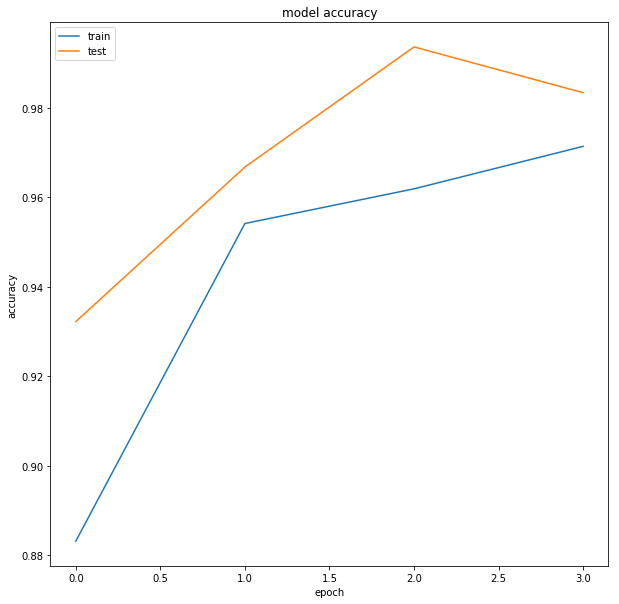

In [0]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Miremos la grafica para el LOSS

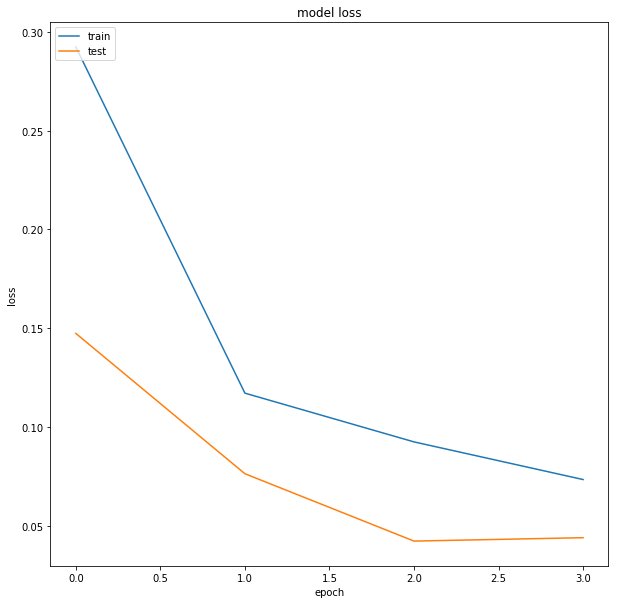

In [0]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()